In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords # Import the stop word list
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score
import matplotlib
%matplotlib inline

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
train_data['neutral'] = train_data.apply(lambda x: 0 if sum(x[2:8])>=1 else 1 ,axis = 1)
print(train_data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  neutral  
0             0        0       0       0              0        1  
1             0        0       0       0              0        1  
2             0        0       0       0              0        1  
3             0        0       0       0              0        1  
4             0        0       0       0              0        1  


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


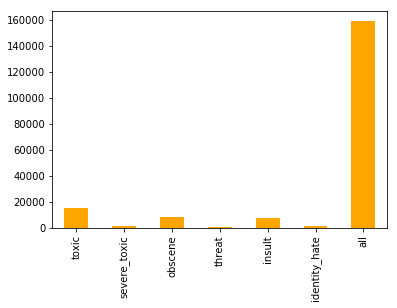

In [6]:
print(train_data.iloc[:,2:8].sum())
count_labels = train_data.iloc[:,2:8].sum()
count_labels.set_value('all',train_data.shape[0])
count_labels.plot('bar',color='orange')

In [7]:
def process_comment_text(txt):
    ntxt = re.sub(r"[^a-zA-Z]", " ", txt)
    ntxt = ntxt.lower()
    return ntxt

train_data['processed'] = train_data.comment_text.apply(process_comment_text)
test_data['processed'] = test_data.comment_text.apply(process_comment_text)
print(train_data.head())
print(test_data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  neutral  \
0             0        0       0       0              0        1   
1             0        0       0       0              0        1   
2             0        0       0       0              0        1   
3             0        0       0       0              0        1   
4             0        0       0       0              0        1   

                                           processed  
0  explanation why the edits made under my userna

# Tfidf Vectorizer and Regression - 1VsAll

In [8]:
vect = TfidfVectorizer(min_df=3,stop_words='english').fit(train_data.processed.values)
x_train_vectorized = vect.transform(train_data.processed.values)
x_test_vectorized = vect.transform(test_data.processed.values)

In [9]:
def class_model(data,labels):
    negative_ind = np.where(labels == 0)[0]
    positive_ind = np.where (labels == 1)[0]
    balance_negative = np.random.choice(negative_ind,size = len(positive_ind),replace = False)
    train_ind = np.concatenate((positive_ind,balance_negative))
    random.shuffle(train_ind)
    data = data[train_ind,:]
    labels = labels[train_ind]
    
    model = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
        ,refit = True
    )
    model.fit(data, labels)
    return model

In [10]:
columns = ['id']
index = test_data.index # array of numbers for the number of samples
res = pd.DataFrame(columns=columns, index = index)
res['id'] = test_data['id']

for c in train_data.columns[2:8]:
    labels = np.array(train_data[c])
    mm = class_model(x_train_vectorized,labels)
    predictions = mm.predict_proba(x_test_vectorized)
    res[c] = predictions[:,np.squeeze(np.where(mm.classes_==1))]

In [11]:
print(res)

                      id     toxic  severe_toxic   obscene    threat  \
0       00001cee341fdb12  0.999904      0.787003  0.999908  0.644637   
1       0000247867823ef7  0.007029      0.184858  0.010332  0.325136   
2       00013b17ad220c46  0.104241      0.217008  0.079215  0.347439   
3       00017563c3f7919a  0.007881      0.107374  0.015868  0.287720   
4       00017695ad8997eb  0.084354      0.159972  0.060338  0.308643   
5       0001ea8717f6de06  0.020446      0.121069  0.012634  0.223215   
6       00024115d4cbde0f  0.011042      0.100106  0.018216  0.203765   
7       000247e83dcc1211  0.983641      0.286882  0.327619  0.402311   
8       00025358d4737918  0.102474      0.185527  0.062630  0.342450   
9       00026d1092fe71cc  0.010193      0.126478  0.014556  0.249553   
10      0002eadc3b301559  0.969531      0.098846  0.942976  0.247873   
11      0002f87b16116a7f  0.155593      0.179420  0.140803  0.316967   
12      0003806b11932181  0.027118      0.127792  0.027602  0.23

In [12]:
res.to_csv('tfid_reg.csv',index=False)